### 车牌提取

In [32]:
# 导入所需模块
import cv2
import numpy as np
from matplotlib import pyplot as plt
#import Regularization

def find_rectangle(contour):

        y, x = [],[]

        for p in contour:
            y.append(p[0][0])
            x.append(p[0][1])

        return [min(y), min(x), max(y), max(x)]


# 显示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

# plt显示彩色图片
def plt_show0(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()
    
# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()  

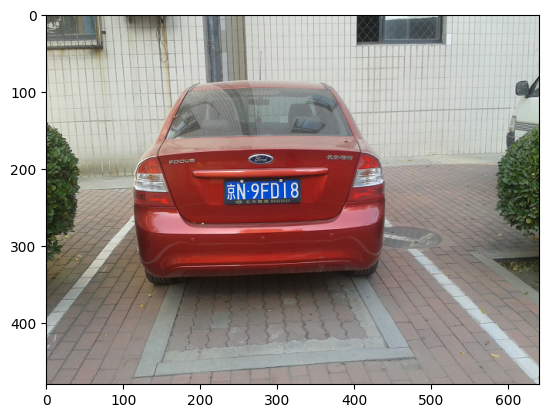

In [33]:
# 加载图片
rawImage = cv2.imread("./license/train 15P/4.bmp")
rawImage_BGR = cv2.cvtColor(rawImage, cv2.COLOR_RGB2BGR)
plt_show0(rawImage)

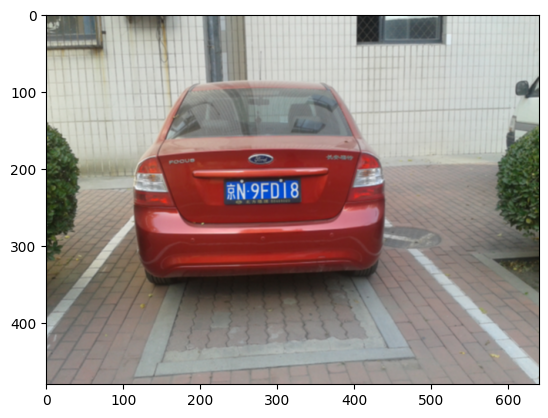

In [34]:
# 高斯去噪
image = cv2.GaussianBlur(rawImage, (3, 3), 0)
# 预览效果
plt_show0(image)

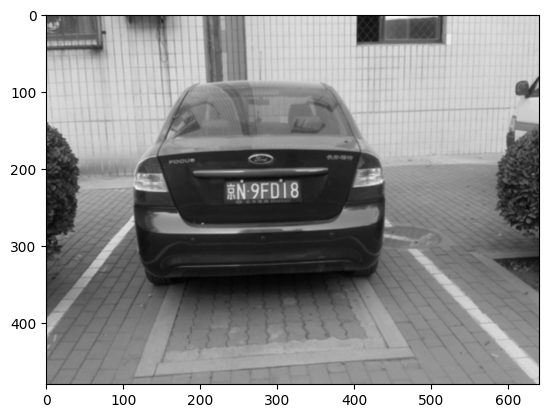

In [35]:
# 灰度处理
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt_show(gray_image)

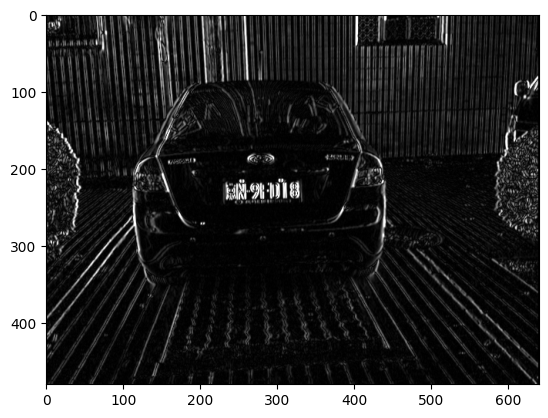

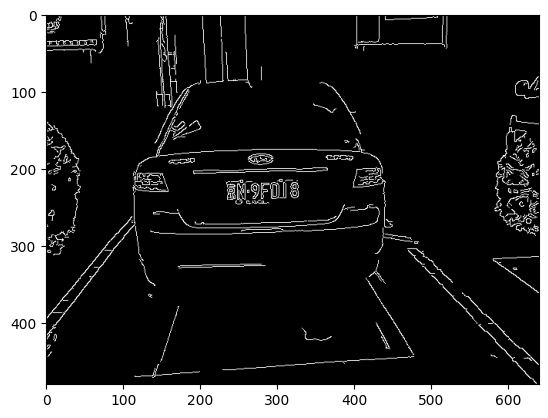

In [36]:
# sobel算子边缘检测（做了一个y方向的检测）
Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
# Sobel_y = cv2.Sobel(image, cv2.CV_16S, 0, 1)
absX = cv2.convertScaleAbs(Sobel_x)  # 转回uint8
# absY = cv2.convertScaleAbs(Sobel_y)
# dst = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
image = absX
plt_show(image)
canny = cv2.Canny(gray_image, 100, 200)
plt_show(canny)
image = canny

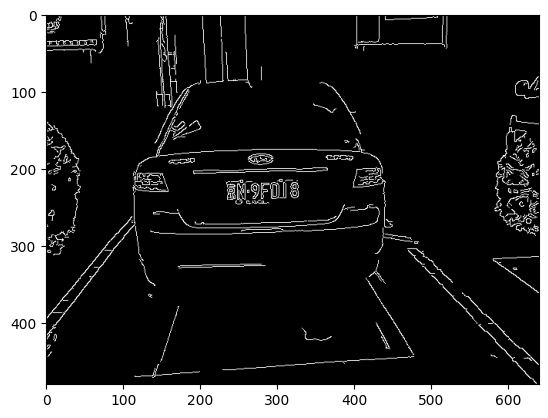

In [37]:
# 自适应阈值处理
ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
plt_show(image)

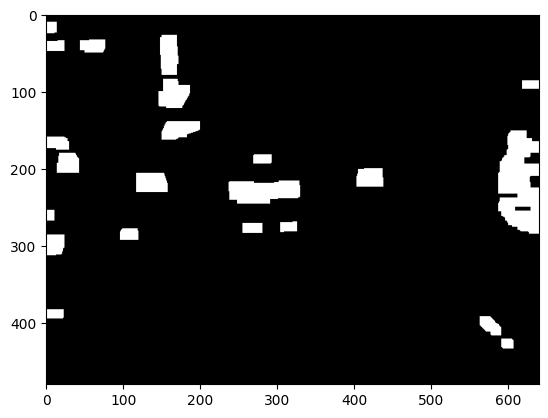

In [38]:
'''消除小的区域，保留大块的区域，从而定位车牌'''
#进行闭运算
kernel = np.ones((5, 20), np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

#进行开运算
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#再次进行开运算
kernel = np.ones((11, 5), np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
plt_show(image)

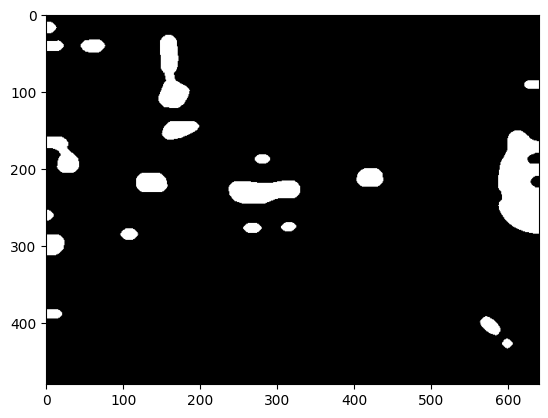

In [39]:
# 中值滤波去除噪点
image = cv2.medianBlur(image, 15)
plt_show(image)

In [40]:
""" # 轮廓检测
# cv2.RETR_EXTERNAL表示只检测外轮廓
# cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素，只保留该方向的终点坐标，例如一个矩形轮廓只需4个点来保存轮廓信息
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
image1 = rawImage.copy()
cv2.drawContours(image1, contours, -1, (0, 255, 0), 5)
plt_show0(image1) """

' # 轮廓检测\n# cv2.RETR_EXTERNAL表示只检测外轮廓\n# cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素，只保留该方向的终点坐标，例如一个矩形轮廓只需4个点来保存轮廓信息\ncontours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n# 绘制轮廓\nimage1 = rawImage.copy()\ncv2.drawContours(image1, contours, -1, (0, 255, 0), 5)\nplt_show0(image1) '

In [41]:
""" # 轮廓数量
len(contours) """

' # 轮廓数量\nlen(contours) '

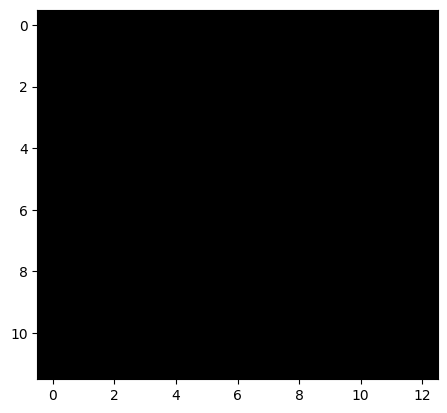

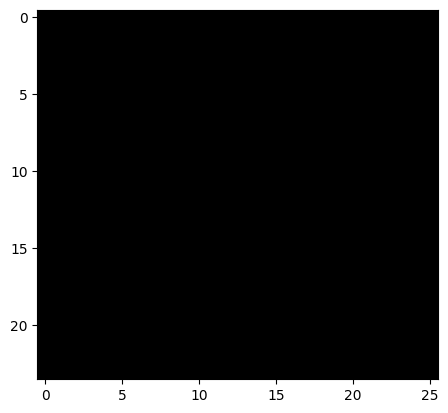

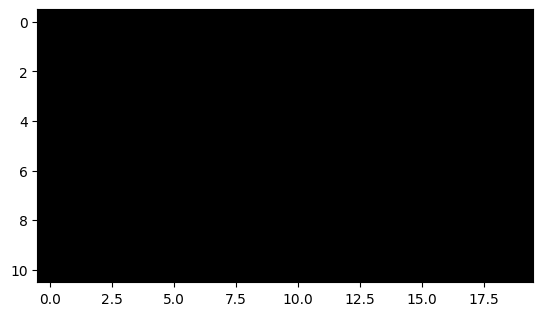

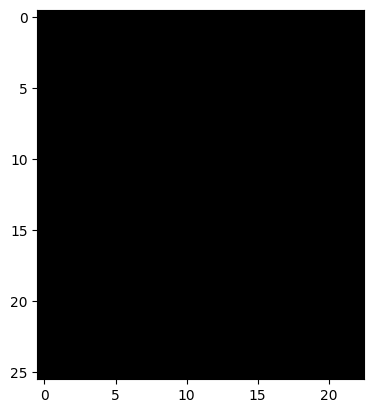

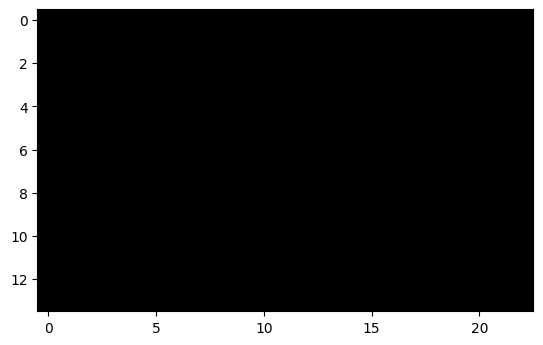

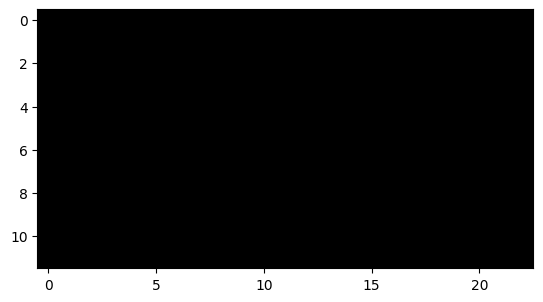

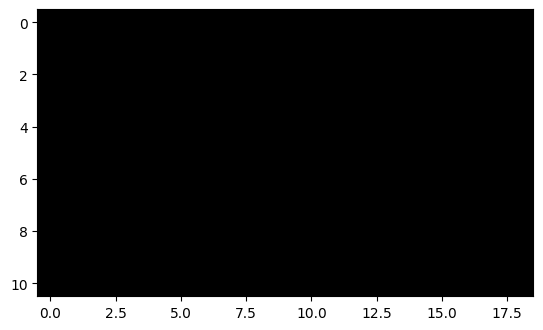

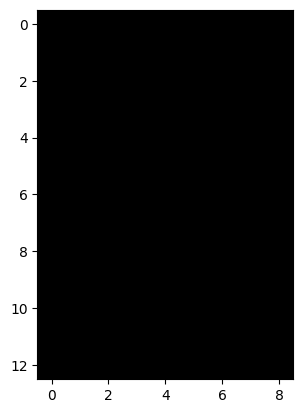

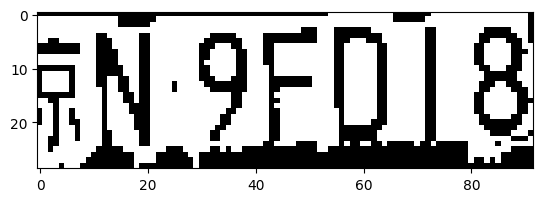

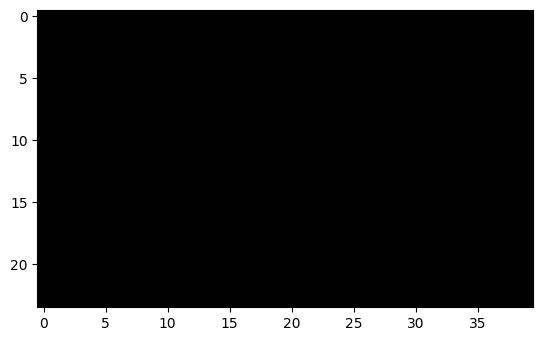

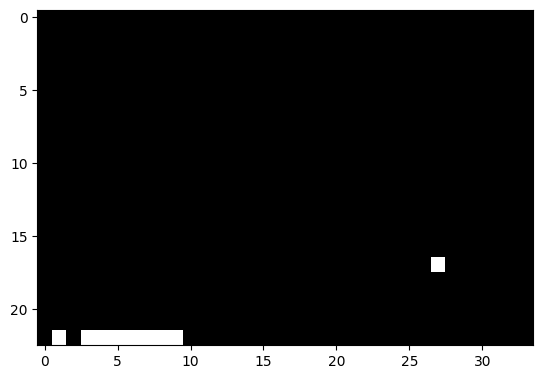

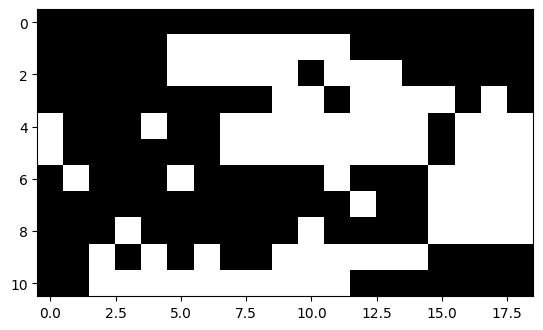

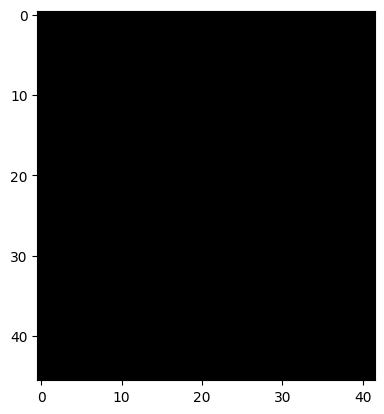

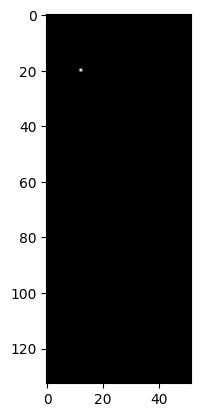

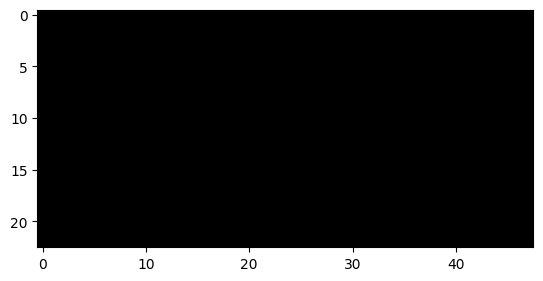

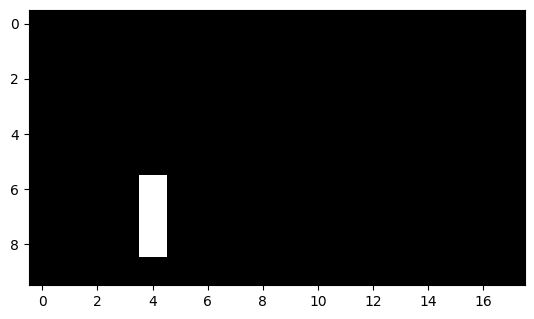

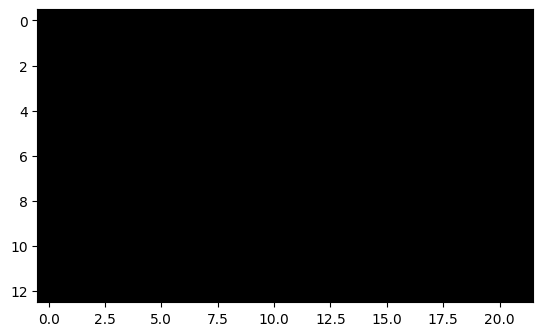

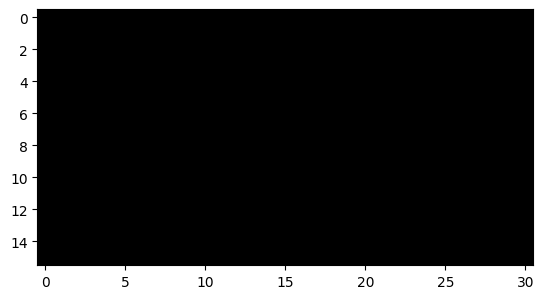

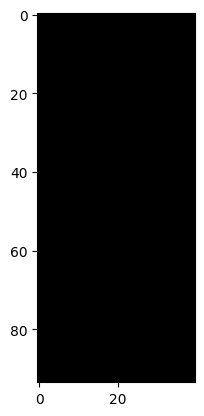

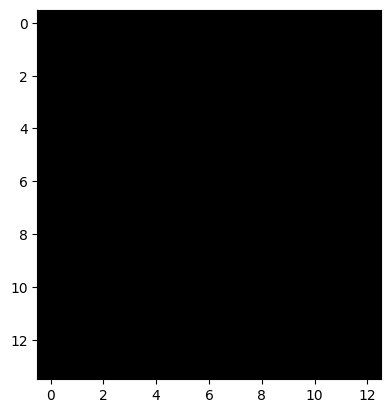

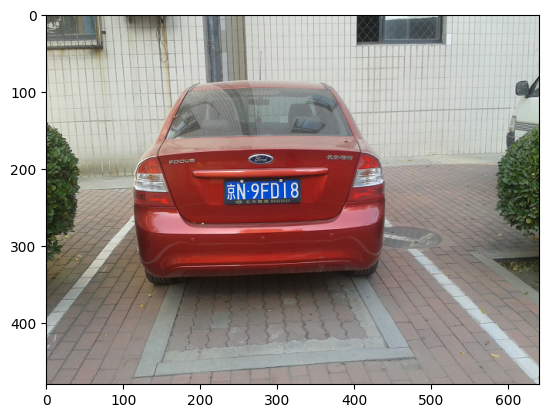

车牌框出: 237 216 329 245


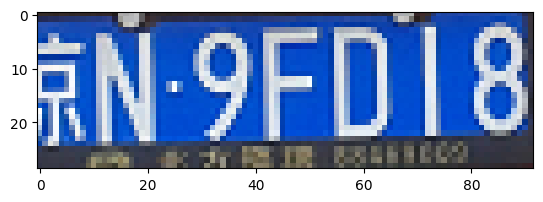

In [42]:
block = []
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    #找出轮廓的左上点和右下点
    #由此计算它的面积和长度比
    r = find_rectangle(c)
    #print('x1, y1, x2, y2',int(r[0]), int(r[1]), int(r[2]), int(r[3]))
    #plt_show0(rawImage[r[1]:r[3], r[0]:r[2]])

    a = (r[2] - r[0]) * (r[3] - r[1])  #面积
    s = (r[2] - r[0]) * (r[3] - r[1])  #长度比

    block.append([r, a, s])

#选出面积最大的3个区域
#block = sorted(block, key=lambda b: b[1])[-3:]

#使用颜色识别判断找出最像车牌的区域
maxweight, maxindex = 0, -1

for i in range(len(block)):
    b = rawImage[block[i][0][1]:block[i][0][3], block[i][0][0]:block[i][0][2]]
    #BGR转HSV
    hsv = cv2.cvtColor(b, cv2.COLOR_BGR2HSV)
    #蓝色车牌的范围
    lower = np.array([100, 50, 50])
    upper = np.array([140, 255, 255])
    #根据阈值构建掩膜
    mask = cv2.inRange(hsv, lower, upper)
    plt_show(mask)
    #统计权值
    w1 = 0
    for m in mask:
        w1 += m / 255

    w2 = 0
    for n in w1:
        w2 += n

    #选出最大权值的区域
    if w2 > maxweight:
        maxindex = i
        maxweight = w2

rect = block[maxindex][0]
# 显示车牌
plt_show(rawImage_BGR)
image3 = rawImage_BGR[rect[1]:rect[3], rect[0]:rect[2]]
print('车牌框出:',int(rect[0]), int(rect[1]), int(rect[2]), int(rect[3]))
plt_show(image3)


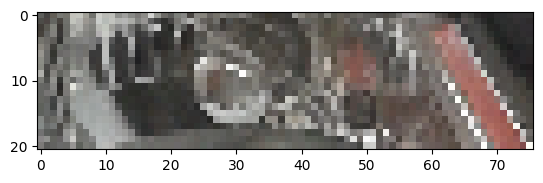

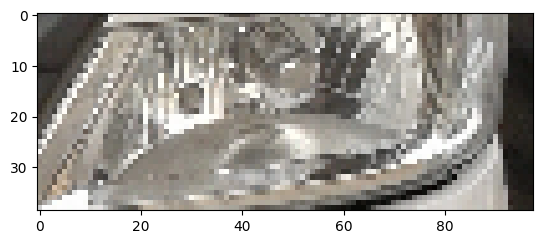

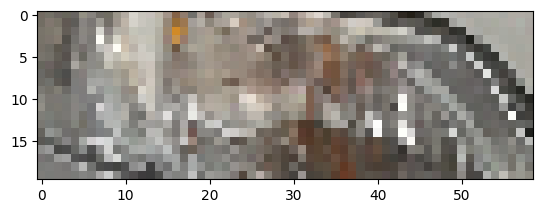

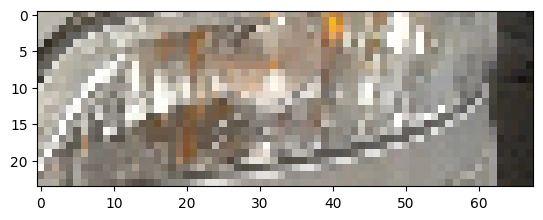

车牌提取成功！


In [75]:
# 筛选出车牌位置的轮廓
# 这里我只做了一个车牌的长宽比在3:1到4：1之间这样一个判断
for item in contours:
    # cv2.boundingRect用一个最小的矩形，把找到的形状包起来
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    # 440mm×140mm
    if (weight > (height * 2.5)) and (weight < (height * 4)):
        abs_image = rawImage[y:y + height, x:x + weight]
#         cv_show('image',image)
        # 图像保存
        plt_show0(abs_image)
        cv2.imwrite('./abstracted_license/2.png', abs_image)
print("车牌提取成功！")

### 车牌字符提取

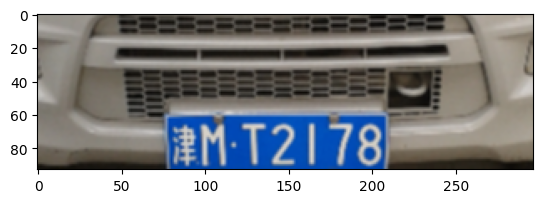

In [48]:
# 高斯去噪
image = cv2.GaussianBlur(abs_image, (3, 3), 0)
# 预览效果
plt_show0(image)

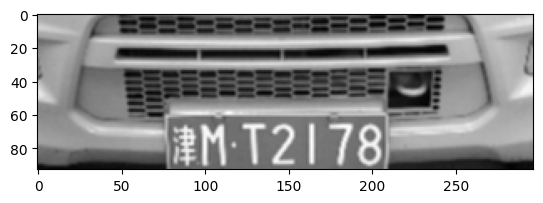

In [49]:
# 灰度处理
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt_show(gray_image)

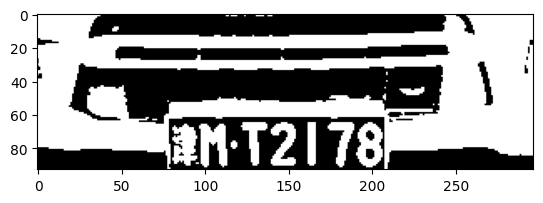

In [50]:
# 自适应阈值处理
ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
plt_show(image)

(93, 297)


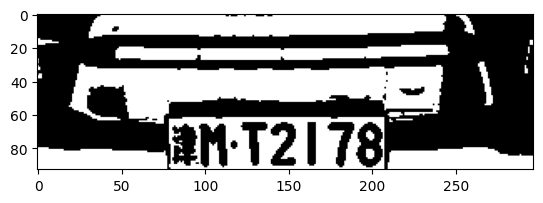

In [51]:
# 计算二值图像黑白点的个数，处理绿牌照问题，让车牌号码始终为白色
area_white = 0
area_black = 0
height, width = image.shape
print(image.shape)
for i in range(height):
    for j in range(width):
        if image[i, j] == 255:
            area_white += 1
        else:
            area_black += 1
if area_white>area_black:
    ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    plt_show(image)

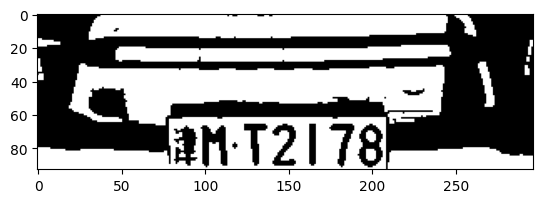

In [52]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
# kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
# kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
# image = cv2.erode(image, kernelX)
# image = cv2.erode(image, kernelY)
image = cv2.dilate(image, kernel)
plt_show(image)
# 闭运算,是白色部分练成整体
# kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# print(kernelX)
# image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX,iterations = 2)
# plt_show(image)

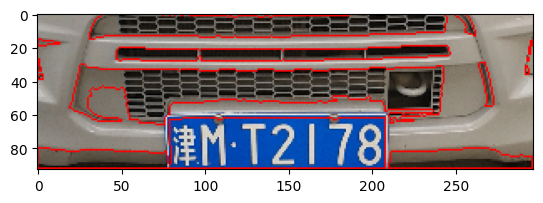

In [53]:
# 轮廓检测
# cv2.RETR_EXTERNAL表示只检测外轮廓
# cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素，只保留该方向的终点坐标，例如一个矩形轮廓只需4个点来保存轮廓信息
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
image1 = abs_image.copy()
cv2.drawContours(image1, contours, -1, (0, 0, 255), 1)
plt_show0(image1)

[[0, 62, 209, 31], [0, 36, 4, 4], [0, 27, 3, 8], [0, 15, 14, 5], [19, 30, 225, 37], [31, 0, 215, 16], [47, 19, 201, 10], [210, 80, 87, 13], [250, 0, 13, 14], [264, 29, 10, 27], [292, 31, 3, 6], [293, 26, 2, 3], [294, 16, 3, 9]]


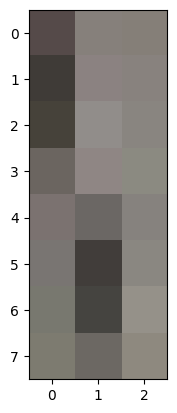

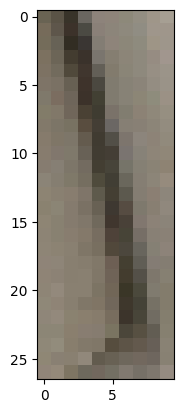

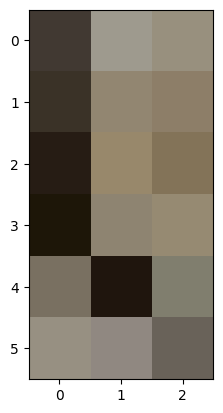

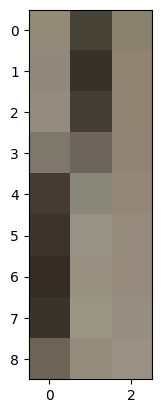

In [54]:
# 筛选出各个字符的位置的轮廓
words = []
for item in contours:
    # cv2.boundingRect用一个最小的矩形，把找到的形状包起来
    word = []
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    word.append(x)
    word.append(y)
    word.append(weight)
    word.append(height)
    words.append(word)
    
words = sorted(words,key=lambda s:s[0],reverse=False)
    
print(words)

i = 0
for word in words:
    if (word[3] > (word[2] * 1.8)) and (word[3] < (word[2] * 3.5)):
        i = i+1
        image = abs_image[word[1]:word[1] + word[3], word[0]:word[0] + word[2]]
        plt_show0(image)
        # gray_image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
        # area_white = 0
        # area_black = 0
        # height, width = image.shape
        # print(image.shape)
        # for i in range(height):
        #     for j in range(width):
        #         if image[i, j] == 255:
        #             area_white += 1
        #         else:
        #             area_black += 1
        # if area_white>area_black:
        #     ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        #     plt_show(image)
        cv2.imwrite('./words/test1_'+str(i)+'.png', image)
